In [198]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import cross_val_score

In [199]:
# Dataset from https://www.kaggle.com/jessemostipak/hotel-booking-demand

df = pd.read_csv('/content/hotel_bookings.csv')

In [200]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [202]:
# Converting string values into ints

In [203]:
# Converting hotel types from str to int

df.hotel = df.hotel.map({'City Hotel':0, 'Resort Hotel':1})
df.hotel.unique()

array([1, 0])

In [204]:
# Converting month from str to int

df.arrival_date_month = df.arrival_date_month.map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September': 9, 'October':10, 'November':11, 'December':12})

In [205]:
# Creating a timeseries date and extraction of weekdays

df['date'] = pd.to_datetime(df['arrival_date_year'].map(str) + '-' + df['arrival_date_month'].map(str) + '-' + df['arrival_date_day_of_month'].map(str))

In [206]:
df['weekday'] = df['date'].dt.weekday

In [207]:
df.meal.unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [208]:
# Converting meal from str to int
df.meal = df.meal.map({'Undefined':0, 'BB':1, 'HB':2, 'FB':3, 'SC':4})

df.meal.unique()

array([1, 3, 2, 4, 0])

In [209]:
# Converting country from str to int using LabelEncoder

df.country.fillna(df.country.mode().to_string(), inplace=True)    # Filling Null values with the most common value in the dataset for the LabelEncoder
le = LabelEncoder()
df.country = le.fit_transform(df.country)
df.country.unique()

array([136,  60, 170,  52,  77,  57,   0, 140, 125, 128,   7, 134,  44,
        16,  30,  35,  67,  82, 124,  47, 141, 155,  12,  53,  43,  26,
        55, 114,  28, 101, 154,   4,  76,  32, 108, 104, 167, 149, 102,
       135, 150,  31,  13,  24, 100, 163, 175,   2,  81,  41, 176,  38,
       177,  49,  92,  39,  73,   6, 162,  83,  72,  70,  78,  61,   5,
        64, 169,  84,  29,  42,  36,  62,  93, 122, 107, 172, 153,  56,
        87, 129,  74,  95, 132, 145, 156,  14,  21, 127, 159,  48, 109,
       118,   8,  86,  99,  40,  34,  23, 116,  37, 152, 166,  20,  33,
        85, 157, 146,  15, 143, 174, 133, 139,  51, 131, 111, 117,  50,
       106,  80, 171, 126,  22, 103, 158, 164,  45, 151,  91,  54,  79,
        71, 142,  89, 105,  19,  75, 160, 123,  17, 173, 165,  59,  63,
       161,  65,  88,  98,  66, 113, 168, 119,  58, 112, 130,  18,  96,
       110, 120,  25, 137,  27,   1,   3, 148,  46, 138,  69,  97,  10,
        68,   9, 115, 121,  90, 144,  11, 147,  94])

In [210]:
df.market_segment.unique()

array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO',
       'Complementary', 'Groups', 'Undefined', 'Aviation'], dtype=object)

In [211]:
# Converting market_segment from str to int

le = LabelEncoder()
df['market_segment'] = le.fit_transform(df['market_segment'])
df.market_segment.unique()

array([3, 2, 6, 5, 1, 4, 7, 0])

In [212]:
df.distribution_channel.unique()

array(['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS'], dtype=object)

In [213]:
# Converting distribution_channel from str to int

df.distribution_channel = df.distribution_channel.map({'Undefined':0, 'Direct':1, 'Corporate':2, 'TA/TO':3, 'GDS':4})
df.distribution_channel.unique()

array([1, 2, 3, 0, 4])

In [214]:
df.reserved_room_type.unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B'], dtype=object)

In [215]:
df.assigned_room_type.unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'I', 'B', 'H', 'P', 'L', 'K'],
      dtype=object)

In [216]:
# Creating a new feature: room. 
# If a guest does not get the reserved room it might raise the probability that she cancels the reservation.

df['room'] = 0
df.loc[df.reserved_room_type == df.assigned_room_type , 'room'] = 1

In [217]:
# Converting reserved_room_type from str to int

le = LabelEncoder()
df['reserved_room_type'] = le.fit_transform(df['reserved_room_type'])
df.reserved_room_type.unique()

array([2, 0, 3, 4, 6, 5, 7, 8, 9, 1])

In [218]:
# Converting assigned_room_type from str to int

le = LabelEncoder()
df['assigned_room_type'] = le.fit_transform(df['assigned_room_type'])
df.assigned_room_type.unique()

array([ 2,  0,  3,  4,  6,  5,  8,  1,  7, 11, 10,  9])

In [219]:
# Creating a new column: net_cancelled. It contains 1 if the guest has cancelled more bookings in the past than the number of booking she did not cancel, otherwise 0

df['net_cancelled'] = 0
df.loc[ df.previous_cancellations > df.previous_bookings_not_canceled, 'net_cancelled'] = 1


In [220]:
df.deposit_type.unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

In [221]:
# Converting deposit_type from str to int

df.deposit_type = df.deposit_type.map({'No Deposit':0, 'Refundable':1, 'Non Refund':2})
df.deposit_type.unique()

array([0, 1, 2])

In [222]:
df.customer_type.unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [223]:
# Converting customer_type from str to int

df.customer_type = df.customer_type.map({'Transient':1, 'Transient-Party':2, 'Contract':3, 'Group':4})
df.customer_type.unique()

array([1, 3, 2, 4])

In [224]:
df.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [225]:
# Converting reservation_status from str to int

df.reservation_status = df.reservation_status.map({'No-Show':0, 'Check-Out':1, 'Canceled':2})
df.reservation_status.unique()

array([1, 2, 0])

In [226]:
df.required_car_parking_spaces.unique()

array([0, 1, 2, 8, 3])

In [227]:
df.shape

(119390, 36)

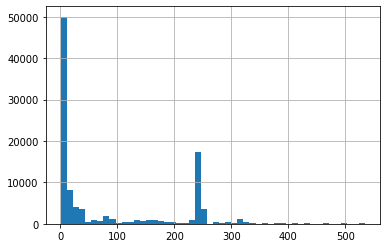

In [228]:
df.agent.hist(bins = 50)


In [230]:
df['company'].mean()

189.26673532440782

In [231]:
# Filling missing values in children with the mean
df.children.fillna(round(df.children.mean()), inplace = True)

# Filling missing values with mode
df['agent'] = df['agent'].fillna(df['agent'].mean())
df['company'] = df['company'].fillna(df['company'].mean())

# Converting unneccessary float types into int types
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

In [232]:
# Adults, babies and children cant be 0 at same time, so these 180 rows need to be dropped

df = df.drop(df[(df.adults+df.babies+df.children)==0].index)

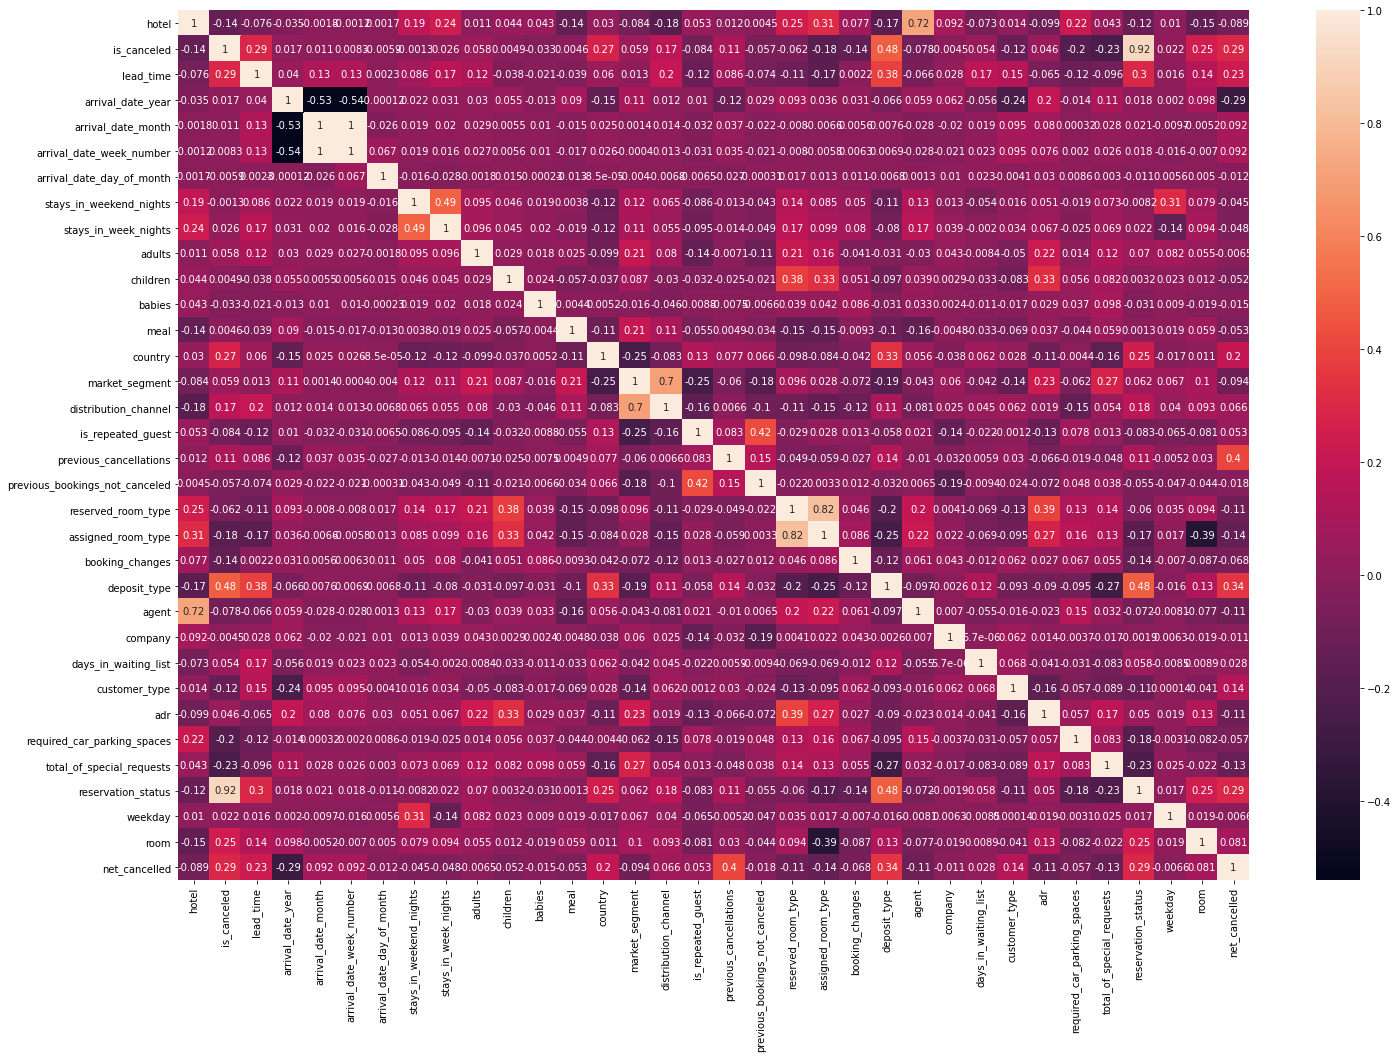

In [233]:
fig, ax = plt.subplots(figsize=(24, 16)) 
sns.heatmap(df.corr(), annot=True, ax = ax)

In [234]:
#Variance of the data
df.var()

hotel                                 0.223085
is_canceled                           0.233300
lead_time                         11422.361808
arrival_date_year                     0.500535
arrival_date_month                    9.546842
arrival_date_week_number            184.990111
arrival_date_day_of_month            77.107192
stays_in_weekend_nights               0.990258
stays_in_week_nights                  3.599010
adults                                0.330838
children                              0.159070
babies                                0.009508
meal                                  0.801927
country                            2023.411409
market_segment                        1.602172
distribution_channel                  0.458395
is_repeated_guest                     0.030507
previous_cancellations                0.713887
previous_bookings_not_canceled        2.244415
reserved_room_type                    2.874866
assigned_room_type                    3.476675
booking_chang

In [235]:
# Correlation depending on is_canceled
df.corr()['is_canceled'].abs().sort_values(ascending = False)

is_canceled                       1.000000
reservation_status                0.917176
deposit_type                      0.480483
net_cancelled                     0.292888
lead_time                         0.292876
country                           0.272496
room                              0.246768
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
assigned_room_type                0.175843
distribution_channel              0.171416
booking_changes                   0.144832
hotel                             0.137082
customer_type                     0.122024
previous_cancellations            0.110139
is_repeated_guest                 0.083745
agent                             0.078351
reserved_room_type                0.062216
market_segment                    0.059419
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
adr                               0.046492
babies     

In [150]:
# vals = [0.005, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]
# y = df['is_canceled']

# # Preparing empty lists for next loop
# val_list, features_list, accuracy_dt_list, kappa_dt_list, accuracy_rf_list, kappa_rf_list, accuracy_xgb_list, kappa_xgb_list = [], [], [], [], [], []
# accuracy_cat_list, kappa_cat_list, accuracy_etc_list, kappa_etc_list = [], [], [], []

# # Loop for automatic prediction using the best found methods for this dataset: Random Forest, XgBoost, Cat, Extra Trees
# for val in vals:
#     features = abs(df.corr()['is_canceled'][abs(df.corr()['is_canceled']) > val]).drop(['is_canceled', 'reservation_status']).index.tolist()

#     # Storing values of val and features per loop
#     val_list.append(val)
#     features_list.append(features)

#     # X = df.drop(columns = ['is_canceled', 'reservation_status', 'date'])
#     X = df
#     X = X[features]

#     X_scaled = StandardScaler().fit_transform(X)
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 4)
    
#     # Decision Tree
#     model_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
#     model_dt_prediction = model_dt.predict(X_test)
#     accuracy_dt = accuracy_score(y_test, model_dt_prediction)
#     kappa_dt = cohen_kappa_score(y_test, model_rf_prediction)

#     # Storing the results of Decision Tree
#     accuracy_dt_list.append(accuracy_dt)
#     kappa_dt_list.append(kappa_dt)

#     # Random Forest
#     model_rf = RandomForestClassifier(n_estimators=800).fit(X_train, y_train)
#     model_rf_prediction = model_rf.predict(X_test)
#     accuracy_rf = accuracy_score(y_test, model_rf_prediction)
#     kappa_rf = cohen_kappa_score(y_test, model_rf_prediction)

#     # Storing the results of Random Forest
#     accuracy_rf_list.append(accuracy_rf)
#     kappa_rf_list.append(kappa_rf)
    
#     # XgBoost Classifier
#     model_xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180).fit(X_train, y_train)
#     model_xgb_prediction = model_xgb.predict(X_test)
#     accuracy_xgb = accuracy_score(y_test, model_xgb_prediction)
#     kappa_xgb = cohen_kappa_score(y_test, model_xgb_prediction)

#     # Storing the results of XgBoost Classifier
#     accuracy_xgb_list.append(accuracy_xgb)
#     kappa_xgb_list.append(kappa_xgb)

#     # Cat Boost Classifier
#     model_cat = CatBoostClassifier(iterations=100).fit(X_train, y_train)
#     model_cat_prediction = model_cat.predict(X_test)
#     accuracy_cat = accuracy_score(y_test, model_cat_prediction)
#     kappa_cat = cohen_kappa_score(y_test, model_cat_prediction)

#     # Storing the results of Cat Boost Classifier
#     accuracy_cat_list.append(accuracy_cat)
#     kappa_cat_list.append(kappa_cat)

#     # Extra Trees Classifier
#     model_etc = ExtraTreesClassifier().fit(X_train, y_train)
#     model_etc_prediction = model_etc.predict(X_test)
#     accuracy_etc = accuracy_score(y_test, model_etc_prediction)
#     kappa_etc = cohen_kappa_score(y_test, model_etc_prediction)

#     # Storing the results of Extra Trees Classifier
#     accuracy_etc_list.append(accuracy_etc)
#     kappa_etc_list.append(kappa_etc)

# df_loop = pd.DataFrame(list(zip(val_list, features_list, accuracy_rf_list, kappa_rf_list, accuracy_xgb_list, kappa_xgb_list, accuracy_cat_list, kappa_cat_list, accuracy_etc_list, kappa_etc_list)), columns =['Val', 'Features', 'Accuracy_RF', 'Kappa_RF', 'Accuracy_XGB', 'Kappa_XGB', 'Accuracy_CAT', 'Kappa_CAT', 'Accuracy_ETC', 'Kappa_ETC'])
# df_loop

In [236]:
X = df.drop(['is_canceled', 'reservation_status', 'reservation_status_date', 'date'], axis = 1)

#X = df.drop(['reservation_status', 'reservation_status_date', 'date'], axis = 1)
y = df['is_canceled']
y = np.array(y)

# Scaling

X_scaled = StandardScaler().fit_transform(X)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 0)

In [153]:
# Decision Tree
model_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
model_dt_prediction = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, model_dt_prediction)

conf_dt = confusion_matrix(y_test, model_dt_prediction)
clf_report_dt = classification_report(y_test, model_dt_prediction)

print(f"Accuracy Score of Decision Tree is : {accuracy_dt}")
print(f"Confusion Matrix : \n{conf_dt}")
print(f"Classification Report : \n{clf_report_dt}")

Accuracy Score of Decision Tree is : 0.8532841204596929
Confusion Matrix : 
[[13054  1865]
 [ 1633  7290]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     14919
           1       0.80      0.82      0.81      8923

    accuracy                           0.85     23842
   macro avg       0.84      0.85      0.84     23842
weighted avg       0.85      0.85      0.85     23842



In [154]:
kappa_dt = cohen_kappa_score(y_test, model_dt_prediction)
kappa_dt

0.6883847558873961

In [238]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=600).fit(X_train, y_train)   # 600: 0.8995050750775941
model_rf_prediction = model_rf.predict(X_test)
version_rf = accuracy_score(y_test, model_rf_prediction)
version_rf

0.8998825601879037

In [239]:
kappa_rf = cohen_kappa_score(y_test, model_rf_prediction)   # 600: 0.7826201039672709
kappa_rf

0.7833328235582573

In [ ]:
X.columns

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'weekday',
       'room', 'net_cancelled'],
      dtype='object')

In [44]:
X.shape

(119210, 32)

In [45]:
X.dtypes

hotel                               int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                  int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int64
babies                              int64
meal                                int64
country                             int64
market_segment                      int64
distribution_channel                int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                  int64
assigned_room_type                  int64
booking_changes                     int64
deposit_type                        int64
agent                               int64
company                           

In [80]:
X.corr()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,weekday,room,net_cancelled
hotel,1.000000,-0.137082,-0.075970,-0.035176,-0.001770,-0.001241,0.001678,0.187816,0.235955,0.010571,0.044013,0.043386,-0.139263,0.030017,-0.084113,-0.183645,0.052526,0.012261,0.004467,0.250476,0.312852,0.076598,-0.169905,0.651293,0.105070,-0.072725,0.014249,-0.098522,0.218961,0.043478,0.010040,-0.147996,-0.088604
is_canceled,-0.137082,1.000000,0.292876,0.016622,0.011179,0.008315,-0.005948,-0.001323,0.025542,0.058182,0.004851,-0.032569,0.004626,0.272496,0.059419,0.171416,-0.083745,0.110139,-0.057365,-0.062216,-0.175843,-0.144832,0.480483,-0.046770,-0.083594,0.054301,-0.122024,0.046492,-0.195701,-0.234877,0.022280,0.246768,0.292888
lead_time,-0.075970,0.292876,1.000000,0.040334,0.131603,0.127046,0.002306,0.085985,0.166892,0.117575,-0.037878,-0.021003,-0.038555,0.059885,0.013277,0.200328,-0.123209,0.086025,-0.073599,-0.105990,-0.171242,0.002230,0.380745,-0.013114,-0.085854,0.170008,0.151092,-0.065018,-0.116624,-0.095949,0.016332,0.141136,0.233977
arrival_date_year,-0.035176,0.016622,0.040334,1.000000,-0.527537,-0.540373,-0.000121,0.021694,0.031203,0.030266,0.054710,-0.013192,0.090076,-0.148809,0.107924,0.012088,0.010281,-0.119905,0.029234,0.092889,0.035753,0.031416,-0.065965,0.056438,0.033682,-0.056348,-0.237912,0.198429,-0.013812,0.108610,0.002005,0.097892,-0.289821
arrival_date_month,-0.001770,0.011179,0.131603,-0.527537,1.000000,0.995101,-0.026335,0.018851,0.019739,0.029239,0.005479,0.010193,-0.014595,0.025322,0.001401,0.014081,-0.031709,0.037473,-0.021745,-0.007978,-0.006563,0.005570,0.007649,-0.017162,-0.033691,0.018801,0.095396,0.079828,0.000325,0.028086,-0.009667,-0.005195,0.092313
arrival_date_week_number,-0.001241,0.008315,0.127046,-0.540373,0.995101,1.000000,0.066572,0.018629,0.016047,0.026567,0.005556,0.010417,-0.017380,0.025978,-0.000399,0.012557,-0.031125,0.035493,-0.021009,-0.008027,-0.005778,0.006311,0.006875,-0.018225,-0.032912,0.022677,0.094909,0.076281,0.001980,0.026202,-0.016140,-0.006965,0.091741
arrival_date_day_of_month,0.001678,-0.005948,0.002306,-0.000121,-0.026335,0.066572,1.000000,-0.016225,-0.028362,-0.001754,0.014550,-0.000235,-0.012508,-0.000085,-0.003988,-0.006809,-0.006471,-0.027027,-0.000306,0.017296,0.012639,0.011266,-0.006829,0.000159,0.003667,0.022532,-0.004102,0.030291,0.008569,0.003026,0.005583,0.005006,-0.012306
stays_in_weekend_nights,0.187816,-0.001323,0.085985,0.021694,0.018851,0.018629,-0.016225,1.000000,0.494175,0.094759,0.046135,0.018607,0.003806,-0.124537,0.115945,0.064510,-0.086009,-0.012769,-0.042859,0.143002,0.084575,0.050191,-0.114378,0.162411,-0.080783,-0.054399,0.016206,0.050670,-0.018520,0.073124,0.307465,0.079274,-0.045160
stays_in_week_nights,0.235955,0.025542,0.166892,0.031203,0.019739,0.016047,-0.028362,0.494175,1.000000,0.096214,0.044652,0.020373,-0.018677,-0.118518,0.109535,0.055100,-0.095302,-0.013976,-0.048873,0.170177,0.098742,0.080018,-0.079872,0.196777,-0.044437,-0.002026,0.033836,0.066847,-0.024933,0.068738,-0.141286,0.094213,-0.048033
adults,0.010571,0.058182,0.117575,0.030266,0.029239,0.026567,-0.001754,0.094759,0.096214,1.000000,0.029409,0.017890,0.025283,-0.099050,0.208325,0.079645,-0.140973,-0.007070,-0.108856,0.214942,0.159739,-0.041472,-0.030831,0.023370,-0.166182,-0.008365,-0.050212,0.224253,0.014438,0.123353,0.082125,0.054619,-0.006475


In [81]:
X.dtypes

hotel                               int64
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                  int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int64
babies                              int64
meal                                int64
country                             int64
market_segment                      int64
distribution_channel                int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                  int64
assigned_room_type                  int64
booking_changes                     int64
deposit_type                        int64
agent                             

In [82]:
X.country.value_counts()

136    48483
60     12120
57     10401
52      8560
44      7285
       ...  
28         1
112        1
9          1
71         1
149        1
Name: country, Length: 178, dtype: int64

In [243]:
pd.Series(y).value_counts()

0    75011
1    44199
dtype: int64

In [244]:
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [248]:

X_scaled = StandardScaler().fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size = 0.2, random_state = 0)

In [249]:
pd.Series(y_resampled).value_counts()

1    75011
0    75011
dtype: int64

In [250]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=600).fit(X_train, y_train)   # 600: 0.8995050750775941
model_rf_prediction = model_rf.predict(X_test)
version_rf = accuracy_score(y_test, model_rf_prediction)
version_rf

0.9322779536743876

In [251]:
kappa_rf = cohen_kappa_score(y_test, model_rf_prediction)   # 600: 0.7826201039672709
kappa_rf

0.8645596802108053